# Execute the following command before running this notebook to ensure that the necessary packages are installed with the proper versions:

## pip install numpy==1.14.2 matplotlib==2.2.2 scipy==1.0.1 scikit-learn==0.19.1 scikit-image==0.13.1 tensorflow==1.7.0

# Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import re
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from skimage import io, transform
import tensorflow as tf

# Set logger to connect to Tensorflow's logger so losses can be output to file for plotting later
<a href="https://stackoverflow.com/questions/40559667/how-to-redirect-tensorflow-logging-to-a-file?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa">source: StackOverflow post -- matlibplotter's solution</a>

In [2]:
import logging

log = logging.getLogger('tensorflow')
log.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(message)s')
fh = logging.FileHandler('tensorflow.log')
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)
log.addHandler(fh)

# Change size of output cell to prevent scroll bars

In [3]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height: 9999999999999px;
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

# Define stuff for visualizing graph
<a href="https://stackoverflow.com/questions/38189119/simple-way-to-visualize-a-tensorflow-graph-in-jupyter?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa">source: StackOverflow post referencing Alex Mordvintsev's solution</a>

In [4]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

# Define functions for loading/augmenting data and building/training the CNN
<a href="https://www.tensorflow.org/tutorials/layers">conv_model function source: Tensorflow documentation</a>

In [5]:
NUM_CLASSES = 6

def load_data():
    if os.path.exists('x_train_augmented.npy') and os.path.exists('y_train_augmented.npy'):
        print "Training data has been augmented by rotating and flipping horizontally"
        x_train = np.load('x_train_augmented.npy').astype('float32')
        y_train = np.load('y_train_augmented.npy').astype('float32')
    else:
        print "Training data is not yet augmented..."
        x_train = np.load('exam2_train_x.npy').astype('float32')
        y_train = np.load('exam2_train_y.npy').astype('float32')
       
    x_test = np.load('exam2_test_x.npy').astype('float32')
    y_test = np.load('exam2_test_y.npy').astype('float32')

    return x_train, y_train, x_test, y_test

def normalize_imgs(training_data):
    return training_data/255.

def rotate_imgs(x, y, degrees=[20]):
    """
        Makes a copy of X and Y -- image and label arrays.
        Rotates each image D degrees left and right.
        Appends these rotated images and their corresponding labels to the copied arrays.
    """
    
    new_x, new_y = [], []
    for image, label in zip(x, y):
        for degree in degrees:
            image_l = transform.rotate(image, degree, mode='edge', resize=False, preserve_range=True)
            image_r = transform.rotate(image, -degree, mode='edge', resize=False, preserve_range=True)
        
            new_x += [image_l, image_r]
            new_y += [label, label]
            
    new_x = np.concatenate((x, np.array(new_x)), axis=0)
    new_y = np.concatenate((y, np.array(new_y)), axis=0)
    
    return new_x.astype('float32'), new_y

def flip_imgs(x, y):
    """
        Makes a copy of X and Y -- image and label arrays.
        Flips each image horizontally.
        Appends these flipped images and their corresponding labels to the copied arrays.
    """
    
    new_x, new_y = [], []
    for image, label in zip(x, y):

        new_x += [np.fliplr(image)]
        new_y += [label]
        
    new_x = np.concatenate((x, np.array(new_x)), axis=0)
    new_y = np.concatenate((y, np.array(new_y)), axis=0)
    
    return new_x.astype('float32'), new_y

def conv_model(features, labels, mode):     
    tf.set_random_seed(42)
    
    input_layer = tf.reshape(features["x"], [-1, 64, 64, 3])

    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu,
        kernel_initializer=tf.contrib.layers.xavier_initializer(seed=42))

    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=64,
        kernel_size=[4, 4],
        padding="same",
        activation=tf.nn.relu,
        kernel_initializer=tf.contrib.layers.xavier_initializer(seed=42))
    
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    
    conv3 = tf.layers.conv2d(
        inputs=pool2,
        filters=128,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.relu,
        kernel_initializer=tf.contrib.layers.xavier_initializer(seed=42))
    
    pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], strides=2)
    
    pool3_flat = tf.reshape(pool3, [-1, 8 * 8 * 128])
    
    dense1 = tf.layers.dense(inputs=pool3_flat, units=1024, activation=tf.nn.relu,
                             kernel_initializer=tf.contrib.layers.xavier_initializer(seed=42))
    
    dropout1 = tf.layers.dropout(inputs=dense1, rate=0.5, seed=42,
                                 training=mode == tf.estimator.ModeKeys.TRAIN)
    
    dense2 = tf.layers.dense(inputs=dropout1, units=512, activation=tf.nn.relu,
                             kernel_initializer=tf.contrib.layers.xavier_initializer(seed=42))
    
    dropout2 = tf.layers.dropout(inputs=dense2, rate=0.5, seed=42,
                                 training=mode == tf.estimator.ModeKeys.TRAIN)

    logits = tf.layers.dense(inputs=dropout2, units=NUM_CLASSES, activation=tf.nn.sigmoid,
                             kernel_initializer=tf.contrib.layers.xavier_initializer(seed=42))
        
    predictions = {
        "classes": tf.argmax(input=logits, axis=1),
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=NUM_CLASSES)
    
    loss = tf.losses.softmax_cross_entropy(
        onehot_labels=onehot_labels, logits=logits, scope="loss_tensor")
    
    logging_hook = tf.train.LoggingTensorHook({"loss" : loss}, every_n_iter=10)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op,
                                         training_hooks = [logging_hook])
    
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(labels=labels, predictions=predictions["classes"])
    }
  
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

# Load in data and, if necessary, augment it by rotating and flipping images

In [6]:
beginning = time.time()
x_train, y_train, x_test, y_test = load_data()
x_train, y_train = shuffle(x_train, y_train, random_state=42)

if x_train.shape[0] == 1020 or y_train.shape[0] == 1020:
    print "Let's rotate and flip the training data images to produce an augmented training set."
    print "This might take a while (20ish minutes)."
    
    start = time.time()
    try:
        print "\tProducing rotated images..."
        x_train, y_train = rotate_imgs(x_train, y_train, degrees=[15, 30])
       
        print "\tProducing horizontally flipped images..."
        x_train, y_train = flip_imgs(x_train, y_train)
        
        print "\nAugmenting the training set took {} seconds.".format(time.time() - start)
       
        print "After rotating and flipping the images of the training set, we have {} images and {} labels.".format(
        x_train.shape[0], y_train.shape[0])
    
        np.save('x_train_augmented.npy', x_train)
        np.save('y_train_augmented.npy', y_train)
    except:
        print "\nERROR: please install skimage in order to perform training set augmentations.\n"

x_train = normalize_imgs(x_train)

Training data is not yet augmented...
Let's rotate and flip the training data images to produce an augmented training set.
This might take a while (20ish minutes).
	Producing rotated images...
	Producing horizontally flipped images...

Augmenting the training set took 3.41536998749 seconds.
After rotating and flipping the images of the training set, we have 10200 images and 10200 labels.


# Train classifier

In [7]:
tf.reset_default_graph()
clf = tf.estimator.Estimator(model_fn=conv_model, model_dir="convnet_model")

train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": x_train},
    y=y_train,
    batch_size=200, 
    num_epochs=None,
    shuffle=False)

start = time.time()
clf.train(
    input_fn=train_input_fn,
    steps=1000)
print "\Training time: {}\n".format(time.time() - start)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f8e8746f050>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': 'convnet_model', '_save_summary_steps': 100}
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use the retry module or similar alternatives.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into convnet_model/

# Evaluate model

In [8]:
train_eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": x_train},
    y=y_train,
    num_epochs=1,
    shuffle=False)

test_eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": x_test},
    y=y_test,
    num_epochs=1,
    shuffle=False)

start = time.time()
train_eval_results = clf.evaluate(input_fn=train_eval_input_fn)
print "\nTRAIN EVAL TIME: {}\n".format(time.time() - start)
print train_eval_results

start = time.time()
test_eval_results = clf.evaluate(input_fn=test_eval_input_fn)
print "\nTEST EVAL TIME: {}\n".format(time.time() - start)
print test_eval_results

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-16-04:25:49
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from convnet_model/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-16-04:26:19
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.99196076, global_step = 1000, loss = 1.0511458

TRAIN EVAL TIME: 30.6694869995

{'loss': 1.0511458, 'global_step': 1000, 'accuracy': 0.99196076}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-16-04:26:19
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from convnet_model/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-16-04:26:20
INFO:tensorflow:Saving dic

# Plot training loss over the number of iterations

Text(0,0.5,'Loss (Softmax Cross Entropy)')

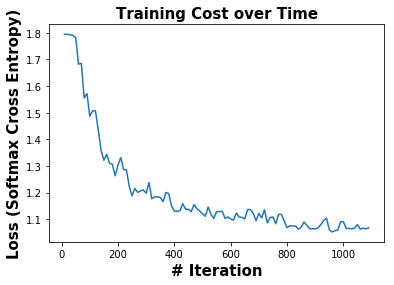

In [9]:
with open('tensorflow.log') as f:
    log_data = f.read()
    
data = []
for d in re.findall(r'loss = [\d]*.[\d]*', log_data)[1:-2]:
    data.append(float(d.split('loss = ')[1]))

formatting = {'fontsize': 15, 'weight': 'bold'}
plt.plot(range(10, 10*len(data)+10, 10), data)
plt.title('Training Cost over Time', formatting)
plt.xlabel('# Iteration', formatting)
plt.ylabel('Loss (Softmax Cross Entropy)', formatting)

# Visualize Tensorflow graph

In [10]:
gdef = tf.GraphDef()
from google.protobuf import text_format
text_format.Merge(open("convnet_model/graph.pbtxt").read(), gdef)
show_graph(gdef)

In [11]:
print "\nEntire notebook executed in {} minutes.".format((time.time() - beginning)/60.)


Entire notebook executed in 29.2085102002 minutes.
